Processing data point: 10000/10000: 100%|██████████| 10000/10000 [00:06<00:00, 1465.47it/s]


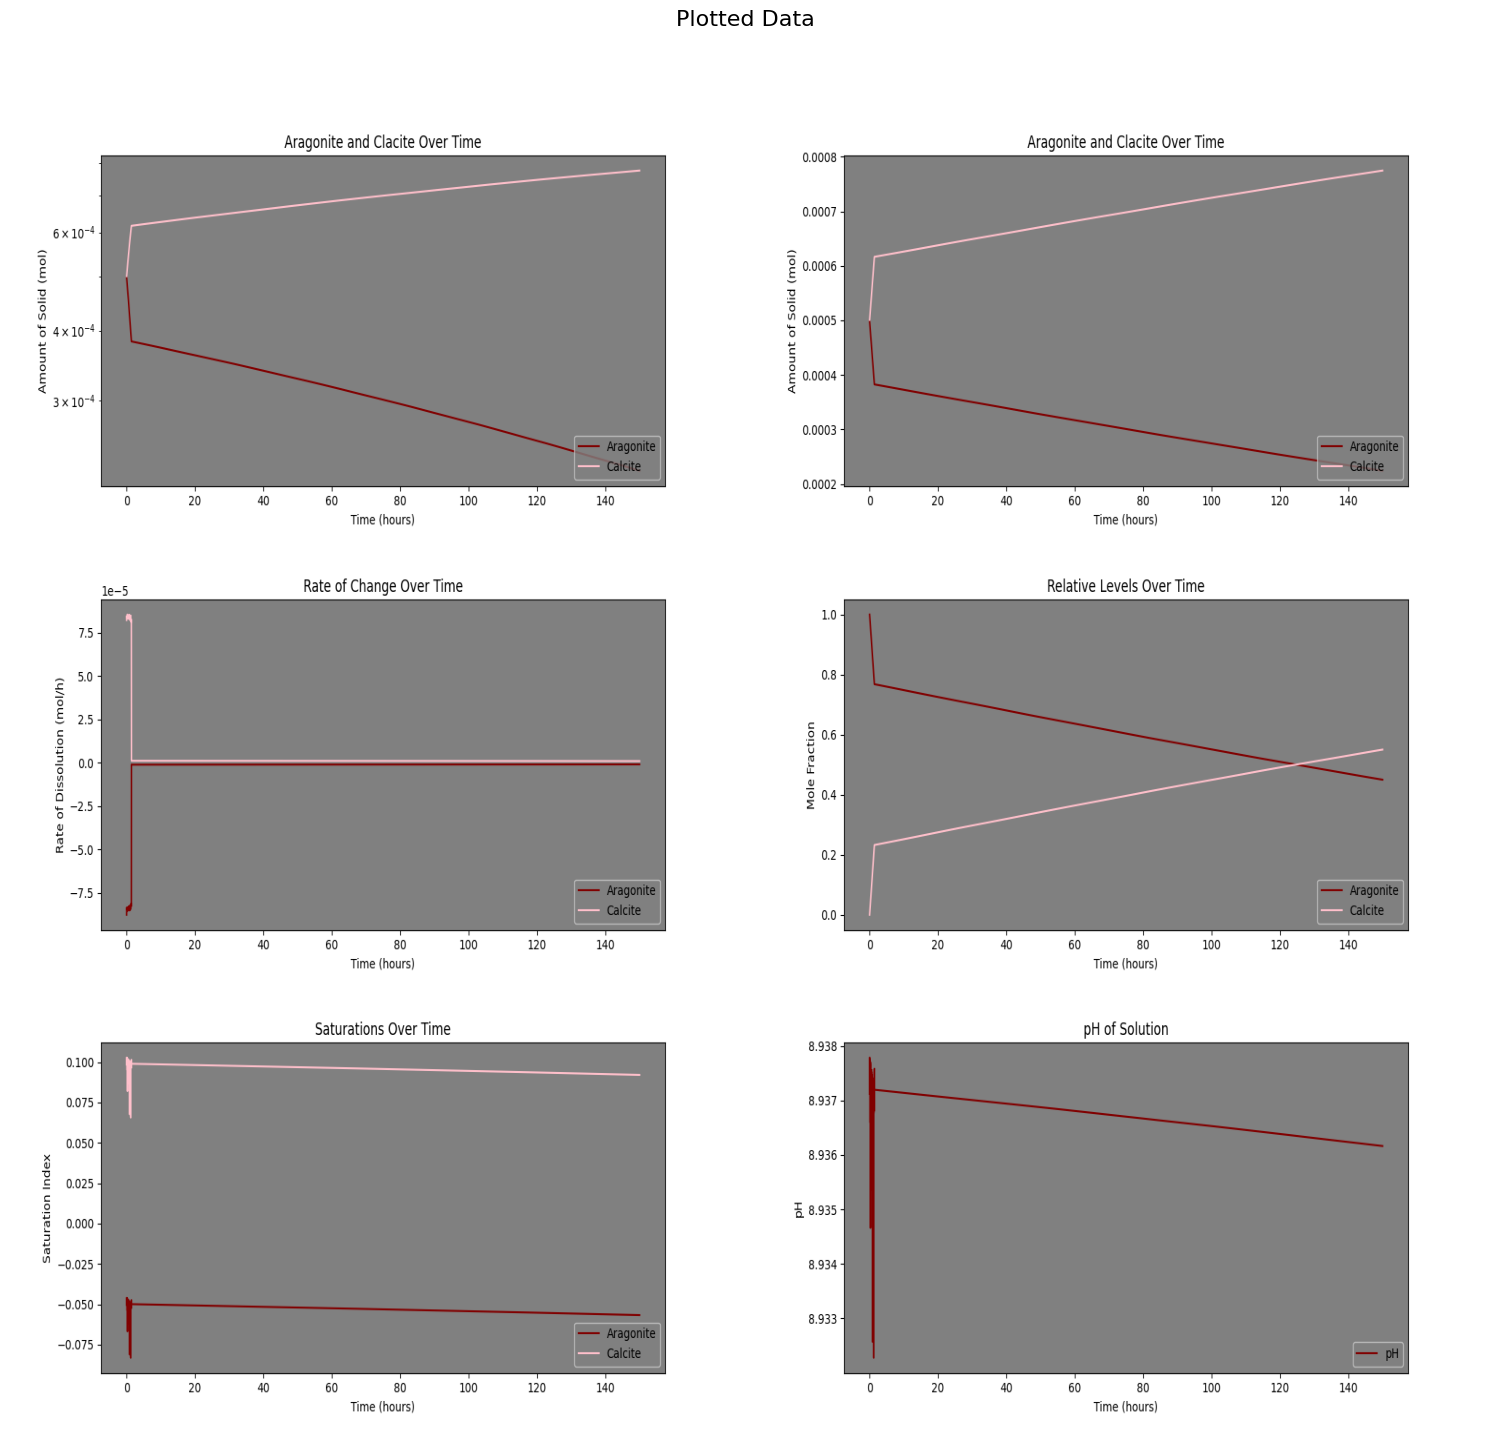

Elapsed time: 14.762109994888306 seconds


In [3]:
"""
The following python code is a conversion of AragoniteDissolution5. A PHREEQC input file which
I wish to convert to PHREEQPY code.
"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time as tim
import io
import sys
import os
import timeit

# Simple Python 3 compatibility adjustment.
if sys.version_info[0] == 2:
    range = xrange

MODE = 'dll'  # 'dll' or 'com'

if MODE == 'com':
    import phreeqpy.iphreeqc.phreeqc_com as phreeqc_mod
elif MODE == 'dll':
    import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
else:
    raise Exception('Mode "%s" is not defined use "com" or "dll".' % MODE)

    
def run_phreeqc(input_string):
    """
    Run PHREEQC simulation with the given input string.
    """
    phreeqc = phreeqc_mod.IPhreeqc()
    phreeqc.load_database(r"C:\Program Files (x86)\USGS\Phreeqc Interactive 3.7.3-15968\database\wateq4f.DAT")
    phreeqc.run_string(input_string)
    return phreeqc

def extract_data(phreeqc, junkrow=1, i = 0):
    """
    Extract data from PHREEQC simulation results and save it to 'data.dat'.
    """
    dictionary = []
    # Get all selected output data as separate lists
    time = phreeqc.get_selected_output_column(0)
    pH = phreeqc.get_selected_output_column(1)
    SI_ara = phreeqc.get_selected_output_column(2)
    SI_cal = phreeqc.get_selected_output_column(3)
    Ara = phreeqc.get_selected_output_column(4)
    dAra = phreeqc.get_selected_output_column(5)
    Cal = phreeqc.get_selected_output_column(6)
    dCal = phreeqc.get_selected_output_column(7)


    while i < junkrow:
        time.pop(0)
        pH.pop(0)
        SI_ara.pop(0)
        SI_cal.pop(0)
        Ara.pop(0)
        dAra.pop(0)
        Cal.pop(0)
        dCal.pop(0)
        i += 1
        
    # Set Column headers.
    header = "Time\tpH\tSI_ara\tSI_cal\tAra\tdAra\tCal\tdCal\n"

    # Save data to 'data.dat'
    with open("data1.dat", "w") as data_file:
        data_file.write(header)
        for i in range(len(time)):
            data_file.write(f"{float(time[i]):.16f}\t{float(pH[i]):.16f}\t{float(SI_ara[i]):.16f}\t{float(SI_cal[i]):.16f}\t"
                            f"{float(Ara[i]):.16f}\t{float(dAra[i]):.16f}\t{float(Cal[i]):.16f}\t{float(dCal[i]):.16f}\n")

    return time, pH, SI_ara, SI_cal, Ara, dAra, Cal, dCal 

def make_plots(time, data1, data2, label1, label2, x_label, y_label, Title, legend_loc='lower right', fig_size=(10, 4.5), semi=False, 
               compare=True, Limits = False, ylU=0, ylL=0, xlU=0, xlL=0):
    """
    Create plots for the given data.

    Parameters:
        time (list): Time data for the x-axis.
        data1 (list): First dataset to plot.
        data2 (list): Second dataset to plot.
        label1 (str): Label for the first dataset.
        label2 (str): Label for the second dataset.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        legend_loc (str, optional): Location of the legend. Default is 'lower right'.
        fig_size (tuple, optional): Size of the figure. Default is (10, 4.5).
        ylimit (Optional): if true will set limits.
        ylU and ylL (Optional): Set the upper and lower limits of the plots y axis.
        xlimit (Optional): if true will set limits.
        xlU and xlL (Optional): Set the upper and lower limits of the plots x axis.
    """

    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_facecolor('grey')
    ax.set_xlabel(x_label, color='black')
    ax.set_ylabel(y_label, color='black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    if compare:
        ax.set_title(Title, color='black')
        if semi:
            ax.semilogy(time, data1, color='Maroon', label=label1)
            ax.semilogy(time, data2, color='Pink', label=label2)
        else:
            ax.plot(time, data1, color='Maroon', label=label1)
            ax.plot(time, data2, color='Pink', label=label2)

        legend = ax.legend(loc=legend_loc, facecolor='grey')
        for text in legend.get_texts():
            text.set_color('black')
    else:
        ax.set_title(Title, color='black')
        if semi:
            ax.semilogy(time, data1, color='Maroon', label=label1)
        else:
            ax.plot(time, data1, color='Maroon', label=label1)

        legend = ax.legend(loc=legend_loc, facecolor='grey')
        legend.get_texts()[0].set_color('black')
    if Limits[0] == True:
        ax.set_xlim(xlL,xlU)
    if Limits[1] == True:
        ax.set_ylim(ylL,ylU)

    return fig

def plot_data(time, SI_ara, SI_cal, Ara, dAra, Cal, dCal, pH, t_unit, xLimits, yLimits, Limits, Titles, Labels, Legend, numplots, semi, compare, datas, dictionary, TTime, TSteps):
    """
    Plot the data extracted from PHREEQC simulation. Also calculates the mole fraction.

    Parameters:
        time (list): Time data.
        SI_ara (list): Saturation Index data for aragonite.
        SI_cal (list): Saturation Index data for calcite.
        Ara (list): Aragonite data.
        dAra (list): Aragonite dissolution rate data.
        Cal (list): Calcite data.
        dCal (list): Calcite dissolution rate data.
        t_unit (str): Time unit for the x-axis.
        TTime = total time
        TSteps = Total steps
    """

    #Calculate the mole fractions
    Null = [0] * len(time)
    totmol = Ara[0]
    stepsize = TTime / TSteps

    χ_ara = [(a / totmol) for a in Ara]
    # χ_Cal = [(c / totmol) for c in Cal]
    χ_cal = [1 - χ for χ in χ_ara]

    xlims = xLimits
    ylims = yLimits
    Limits = Limits
    Titles = Titles
    Labs = Labels

    lists = [Ara, Cal, dAra, dCal, χ_ara, χ_cal, SI_ara, SI_cal, pH]

    # Great globals dictionary
    for i in range(len(lists)):
        globals()[dictionary[i]] = lists[i]

    #Initialize the number of rows and columns
    nrows = int(numplots/2)
    ncols = 2

    # Initialize the progress bar
    progress_bar = tqdm(total=len(dAra))

    for i in range(len(dAra)):
        time[i] = time[i] / 3600
        dAra[i] = dAra[i] / stepsize
        dCal[i] = dCal[i] / stepsize

        # Uncomment the following if you want to have a progress bar, will impact performance!
        # Update the progress bar
        progress_bar.set_description(f"Processing data point: {i + 1}/{len(dAra)}")
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

    count = 0
    while count < numplots:

        name = f"fig{count+1}"
        buffer = f"buffer{count+1}"
        image = f"image{count+1}"
        data = datas[count]
        temp1 = globals()[f"{data[0]}"]
        temp2 = globals()[f"{data[1]}"]

        globals()[name] = make_plots(time, temp1, temp2, Legend[count][0], Legend[count][1], "Time (" + t_unit + ")", Labels[count], Titles[count], semi=semi[count], compare=compare[count],
                          Limits = Limits, ylU=ylims[1], ylL=ylims[0], xlU=xlims[1], xlL=xlims[0])
        
        # Save figures as images in memory
        globals()[buffer] = io.BytesIO()
        globals()[name].savefig(globals()[buffer], format="png")

        # Rewind the buffer and read the image data
        globals()[buffer].seek(0)
        globals()[image] = plt.imread(globals()[buffer])
        plt.close(globals()[name])

        count += 1

    # Create a 3x2 grid to display the plots side by side
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15 ,5 * nrows))
    fig.suptitle("Plotted Data", fontsize=16)

    # Create a 3x2 grid to display the plots side by side
    count = 0
    while count < nrows:
        count2 = 0
        while count2 < ncols:  # Changed the condition from 'count' to 'count2'
            name = f"image{count * ncols + count2 + 1}"
            axes[count, count2].imshow(globals()[name])
            axes[count, count2].axis("off")
            axes[count, count2].set_aspect('auto')  # Set the aspect ratio to auto to fill the available space

            count2 += 1  # Increment the inner loop counter 'count2'   

        count += 1  # Increment the outer loop counter 'count'
        
    # Adjust spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the grid plot
    plt.show()

def Generate_Solutions(Name, temp = "20", pH = "7", units = "mmol/L", density = "1",alkalinity = 0, mass = "1"):
    """
    This function generates a solution which will be saved and returned to main.
    Name == Name of soltuion
    Temp == temperature of solution
    pH == pH of solution
    units == Units of the concentration
    Density == Density of solvent
    mass= = mass of solvent in kg
    """

    Solution = (
        "SOLUTION " + Name + "\n" 
        + "    temp       "+ temp + "\n" 
        + "    pH         " + pH + "\n"  
        + "    units      "+ units + "\n"
        + "    density    " + density+ "\n" 
        + "    Alkalinity " + alkalinity + "\n"
        + "    -water     " + mass
        + "\n\n" )
    
    return Solution

def Mixer(Name, Ratio_1 = 0.5):
    """
    This function generates a mixed solution based on the added components and their ratios to one another.
    Name == Name of newly mixed solution
    Ratio_1 and Ratio_2 are the amounts of each solution in proportion to each other.
    S_ means that the variable is a string.

    """
    Ratio_2 = 1 - Ratio_1 
    S_Ratio_1 = str(Ratio_1)
    S_Ratio_2 = str(Ratio_2)

    Mixed_sol = (
        "MIX " + Name + "\n"
        + "    1 " + S_Ratio_1 + "\n"
        + "    2 " + S_Ratio_2 + "\n"
        + "SAVE Solution 3"
        + "\n\n"
    )
    return Mixed_sol

def Equilibrate(Name, Mineral, CO2 = ["CO2", "-3.5", "10"], Target_SI = "0.0", Addsolid = "0.0", CO2eq = False):
    """
    This function calls and sets the equilibrium_phases block.
    Name == The name of the final solution.
    Mineral == Name of the mineral
    Target_SI == The desired saturation of the mineral
    Addsolid == The ammount of solid added to acheive this

    """
    if CO2eq == False:
        Eq = (
            "EQUILIBRIUM_PHASES " + Name + "\n"
            + "    " + Mineral + " " + Target_SI + " " + Addsolid + "\n"
            + "SAVE Solution " + Name
            + "\n"
        )
    elif CO2eq == True:
        Eq = (
            "EQUILIBRIUM_PHASES " + Name + "\n"
            + "    " + Mineral + " " + Target_SI + " " + Addsolid + "\n"
            + "    " + CO2[0]  + " " + CO2[1] + " " + CO2[2] + "\n"
            + "SAVE Solution " + Name
            + "\n"
        )

    return Eq

def Set_Rates(Name, Amount = 2, Minerals = ["Aragonite" , "Calcite"], Surface_Area = [100000, 100000], Molar_mass = [100.09, 100.09]):
    """
    The following sets up the RATES block.
    Name == The name of the rates block. I just number them.
    Amount == Number of minerals which need rates. It is assumed they follow a similar type of equation
    Minerals == The names of the minerals
    Surface_Area == The Area per gram of Solid
    Molar_mass == The molar mass of solid

    """
    ###The following initializes the countner and sets the header for the block
    i = 0
    Rates1 = "RATES " + Name + "\n"
    Rates2 = ""

    ###Iterates to make each segment of the rates block
    while i < Amount:
        mineral = Minerals[i]
        molmass = Molar_mass[i]
        SA = Surface_Area[i]
        TempRate = ("    " + str(mineral) + "\n" 
                + "    -start""" + "\n"
                + "    10 IF (TOTAL_TIME <= parm(4)) THEN k = 10^parm(1)" + "\n"
                + "    20 IF (TOTAL_TIME > parm(4)) THEN k = 10^parm(2)" + "\n"
                + "    30 n = parm(3)" + "\n"
                + "    40 A = " + str(SA)  +  " * " + str(molmass)  + ' * KIN("' + str(mineral) + '")' + "\n"
                + '    50 R = (k *A *  (1 - SR("' + mineral + '"))^n)' + "\n"
                + "    60 SAVE R * time" + "\n"
                + "    -end" + "\n"
        )
        Rates2 += TempRate
        i += 1
    Rates = Rates1 + Rates2 + "\n\n"
    return Rates

def Set_Kinetics(Name, Solution, Amount = 2, Minerals = ["Aragonite" ,"Calcite"], Formulas = ["CaCO3 1", "CaCO3 1"], masses = ["0", "0"],
                 Orders = ["3","5"], EqConstants1 = ["-8.34","-8.48"], EqConstants2 = ["-10.19","-10.33"], ChngTime = "5040", Tolerance = "1e-08",
                 Time = "100", Steps = "1000", unit = "hour"):
    """
    This function sets up and initializes the kinetics block.
    Name == Name of this block, I use numbers
    Solution == The solution the kniteics occurs in (REQUIRED TO RUN MAKE SURE TO DEFINE)
    Amount == The number of minerals which will react
    Minerals == The names of the minerals
    Formulas == The Chemical formula for the compounds
    mass = mass of solid
    Orders == the orders of each reactions
    EqConstants1 == the Constants for the first part of the reaction
    EqConstants2 == The constants for the second part of the reaction
    ChngTime == The time which the first and second parts of the reaction change.
    Tolerance == The allowed error
    Time == Timespan of the reaction
    Steps == number of steps
    unit == units of time
    """
    
    ###Initialize the counter and the first line of the block
    i = 0
    Kinetics1 = "KINETICS " + Name + "\n"
    Kinetics2 = "" 

    ###Define the loop
    while i < Amount:
        mineral = Minerals[i]
        order = Orders[i]
        EqConstant1 = EqConstants1[i]
        EqConstant2 = EqConstants2[i]
        Formula = Formulas[i]
        mass = masses[i]

        tempkinetics = ("    " + str(mineral) + "\n"
                    + "        -formula  " + str(Formula) + "\n"
                    + "        -m0       " + str(mass) + "\n"
                    + "        -parms    " + str(EqConstant1) + " " + str(EqConstant2) + " " + str(order) + " " + ChngTime + "\n"
                    + "        -tol      " + Tolerance + "\n" 
        )
        Kinetics2 += tempkinetics
        i += 1

    Kinetics3 = ( "-steps    " + Time + " " + unit + " " + "in " + Steps + "\n"
             + "-step_divide 1" + "\n"
             + "-runge_kutta 6" + "\n"
             + "-bad_step_max 500" + "\n"
             + "INCREMENTAL_REACTIONS true" + "\n"
             + "\n"
             + "USE Solution " + Solution  + "\n"
    )

    Kinetics = Kinetics1 + Kinetics2 + Kinetics3

    return Kinetics

def Generate_Input(Solution_1 = "", Solution_2 = "", Solution_3 = "", Eq1 = "", Eq2 = "", Rates = "", Kinetics = ""):
    input_string = (
    Solution_1 + 
    Eq1 + 
    Solution_2 + 
    Eq2 +
    Solution_3 +
    """END \n\n"""
    + Rates
    + Kinetics +
    """

    SELECTED_OUTPUT 1
        -high_precision       true
        -reset                false
        -time                 true
        -saturation_indices   Aragonite  Calcite
        -kinetic_reactants    Aragonite  Calcite
        -pH                   true
    END
    
    """)

    return input_string

def main(Minerals, pHs, temps, Names, units, Wmasses, Smasses, CO2s, CO2eq, alkalinity,
         Eqconstants1, Eqconstants2, Orders, chngTime, Surface_Areas,Molar_masses, 
         Time, Steps, LUnit, Tolerance, xLimits, yLimits, Limits, Titles, Labels, Legend, numplots, semi, compare, datas, dictionary):
    
    start_time = tim.time()
    #Define the units of time
    t_unit = "hours"
    
    """
    Main function to execute the PHREEQC simulation and plot the results.
    """
    plt.style.use('default')
    ### Make and mix Solutions
    Solution_1 = Generate_Solutions(Names[0], temp = temps[0], pH = pHs[0], units = units[0], alkalinity = alkalinity[0], mass = Wmasses[0])
    Solution_2 = Generate_Solutions(Names[1], temp = temps[1], pH = pHs[1], units = units[1], alkalinity = alkalinity[0], mass = Wmasses[1])
    Solution_3 = Mixer(Names[0], Ratio_1 = 0.5)
    Eq1 = Equilibrate(Names[0], Minerals[0], Addsolid = Smasses[0], CO2 = CO2s[0], CO2eq = CO2eq[0])
    Eq2 = Equilibrate(Names[0], Minerals[1], Addsolid = Smasses[1], CO2 = CO2s[1], CO2eq = CO2eq[1])

    ### Set up the kinetics
    Rates = Set_Rates(Names[0], Amount = len(Minerals), Minerals = Minerals, Surface_Area = Surface_Areas, Molar_mass = Molar_masses)
    Kinetics = Set_Kinetics(Name = Names[0], Solution = "3", Amount = 2, Minerals = Minerals, masses = Kmasses,
                            Orders = Orders, EqConstants1 = Eqconstants1, EqConstants2 = Eqconstants2, ChngTime = chngTime, 
                            Tolerance = Tolerance, Time = Time, Steps = Steps, unit = LUnit)

    input_string = Generate_Input(Solution_1 = Solution_1, Solution_2 = Solution_2, Solution_3 = Solution_3, Eq1 = Eq1, Eq2 = Eq2, Rates = Rates, Kinetics = Kinetics)
    phreeqc = run_phreeqc(input_string)
    time, pH, SI_ara, SI_cal, Ara, dAra, Cal, dCal = extract_data(phreeqc, junkrow = 1)
    
    plot_data(time, SI_ara, SI_cal, Ara, dAra, Cal, dCal, pH, t_unit, xLimits, yLimits, Limits, Titles, Labels, Legend, numplots, semi, compare, datas,
              dictionary, TTime = float(Time), TSteps = float(Steps))

    end_time = tim.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    return time, pH, SI_ara, SI_cal, Ara, dAra, Cal, dCal, input_string

if __name__ == '__main__':
    
    ###Solution information
    Minerals = ["Aragonite", "Calcite"]
    pHs = ["6.5","6.5"]
    temps = ["18", "18"]
    Names = ["1", "2", "3"]
    units = ["mmol/L", "mmol/L"]
    Wmasses = ["0.01", "0.01"] #Water masses
    Smasses = ["0.0004995", "0.0004995"] #Masses of Solids for equlibrate function
    CO2s = [["CO2(g)", "-3.5", "10"], ["CO2(g)", "-3.5", "10"]]
    CO2eq = [True, True]
    alkalinity = ["5", "5"]


    ###Kinetics information
    Eqconstants1 = ["-8.34","-8.48"]
    Eqconstants2 = ["-10.19","-10.33"]
    Orders = ["3", "5"]
    chngTime = "5040" #Time when the Eq. Constants change
    Surface_Areas = [100000, 100000]
    Molar_masses = [100.09, 100.09]
    Kmasses = ["0.0004995", "0.0004995"]

    ###Loop information
    Time = "150"
    Steps = "10000"
    LUnit = "hour" #Units of time
    Tolerance = "1e-08"

    ###Plotting information
    xLimits = [0, float(Time) - 140]
    yLimits = [0, 0]
    Limits = [False, False]
    numplots = 6
    Titles = ["Aragonite and Clacite Over Time", "Aragonite and Clacite Over Time", "Rate of Change Over Time", "Relative Levels Over Time", "Saturations Over Time", "pH of Solution" ]
    Labels = ["Amount of Solid (mol)","Amount of Solid (mol)", "Rate of Dissolution (mol/h)", "Mole Fraction","Saturation Index", "pH"]
    Legend = [["Aragonite", "Calcite"], ["Aragonite", "Calcite"], ["Aragonite", "Calcite"], ["Aragonite", "Calcite"], ["Aragonite", "Calcite"], ["pH", ""]]
    semi = [True, False, False, False, False, False]
    compare = [True, True, True, True, True, False]
    datas = [["Ara", "Cal"], ["Ara", "Cal"], ["dAra", "dCal"], ["χ_ara", "χ_cal"], ["SI_ara", "SI_cal"], ["pH", "pH"]]

    #Dictionary
    dictionary = ["Ara", "Cal", "dAra", "dCal", "χ_ara", "χ_cal", "SI_ara", "SI_cal", "pH"]

    (time, pH, SI_ara, SI_cal, Ara, dAra, Cal, dCal, input_string) = main(Minerals, pHs, temps, Names, units, Wmasses, Smasses, CO2s, CO2eq, alkalinity,
                                                                          Eqconstants1, Eqconstants2, Orders, chngTime, Surface_Areas,
                                                                          Molar_masses, Time, Steps, LUnit, Tolerance,
                                                                          xLimits, yLimits, Limits, Titles, Labels, Legend, numplots, semi, compare, datas,
                                                                          dictionary)

